# Fly-QMA Tutorial

This notebook is designed to walk the user through some of the basic functionalities offered by Fly-QMA. For more detailed explanations of all available functionalities please refer to the Fly-QMA documentation.

Throughout this tutorial we'll use an example dataset; a single 3D confocal image stack containing three fluorescence reporter channels:

- Channel 0: DAPI nuclear stain
- Channel 1: HisRFP clonal marker
- Channel 2: PntGFP control reporter

Note that the control reporter should be expressed equally within a strip of cells near the morphogenetic furrow, but due to fluorescence bleedthrough from the clonal marker it shows variegated expression. We will correct for that later in the tutorial.

To get started, let's import a handful of settings and packages to help out with some basic operations and visualization.

In [1]:
#import sys, flyqma
#sys.modules['clones'] = flyqma

from os.path import join
import numpy as np
from flyqma.visualization.settings import *
import matplotlib.pyplot as plt
%matplotlib inline

# Load raw microscopy data

To load our image stack, we need to define a path to an otherwise empty directory containing a multi-channel tif file.

In [2]:
stack_path = '../data/replication_data/tutorial/1'

We may then instantiate a ```Stack``` object. This instance represents the entire 3D image stack. To limit unnecessary memory usage, the stack instance does not load the actual image data unless we explicitly tell it to using the ```load_image``` method. Note that we must correctly define the bit depth upon instantiation, e.g. whether our tif uses an 8, 12, or 16 bit container.

In [3]:
from flyqma.data.stacks import Stack

stack = Stack(stack_path, bits=12)
stack.load_image()

# Visualize layers within an image stack

At this point we can readily select individual layers, either using the ```load_layer``` method or simply by indexing the ```Stack``` instance. Both of these operations return a ```Layer``` instance, which represents an individual layer within the image stack. The former is more verbose but offers a bit more functionality, such as a ```process=False``` option that loads saved measurements directly from a file rather than re-processing (annotation, bleedthrough correction, etc.) them as they are loaded.

In [4]:
layer_id = 0
layer = stack[layer_id]

# alternatively, with a bit more functionality
layer = stack.load_layer(layer_id)

We can visualize a layer using the ```Layer.show``` method. See the documentation for details on all the various options. 

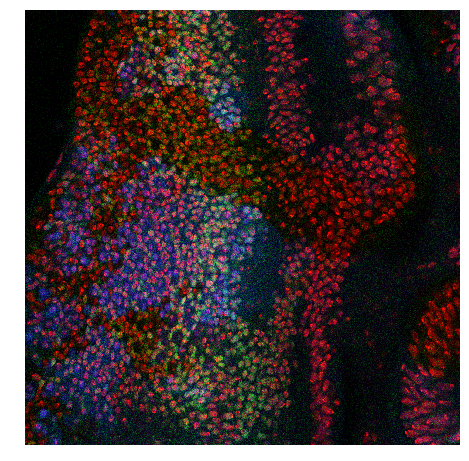

In [5]:
_ = layer.show(figsize=(8, 8))

We may also visualize individual fluorescence channels within each layer by using the ```Layer.get_channel``` method, which returns an ```ImageScalar``` instance representing the individual channel. This instance provides all the same visualization options as it's parent multichannel layer.

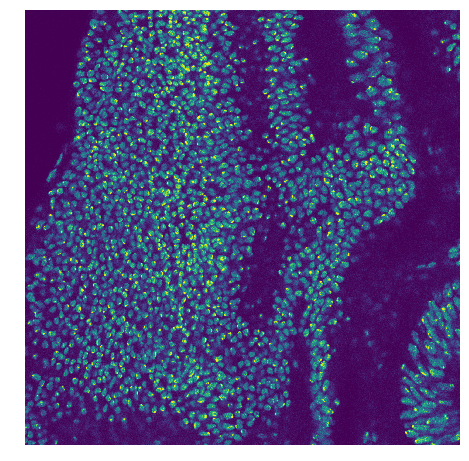

In [6]:
channel_id = 0
dapi = layer.get_channel(channel_id)

# visualize the DAPI stain
_ = dapi.show(figsize=(8, 8))

# Segment each layer to identify cell nuclei

We can now segment each layer in the image stack. We can do this on a layer-by-layer basis using the ```Layer.segment``` method, or just use the ```Stack.segment``` method to perform the segmentation for all layers in the stack.

Either way, we need to define which channel represents the nuclear stain, which in this case is "Channel 0" or DAPI. The segmentation algorithm used relies upon several seed detection strategies followed by a watershed segmentation. Parameters for each of these operations may be supplied as keyword arguments; see the Fly-QMA documentation for further details.

In [7]:
segmented_channel_id = 0

stack.segment(channel=segmented_channel_id)

Once the segmentation is complete, we can visualize the identified contours in the same manner as before. The ```segments``` argument determines whether or not individual contours are visualized.

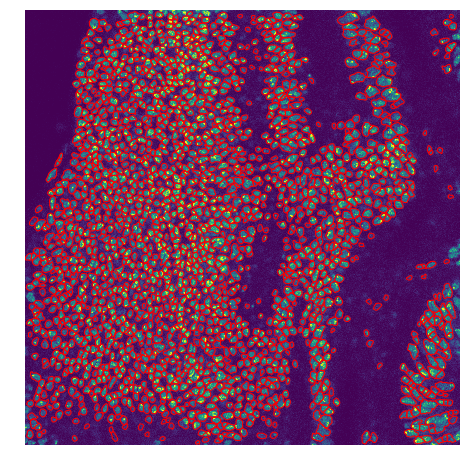

In [8]:
image = stack[layer_id].get_channel(segmented_channel_id)

_ = image.show(segments=True, figsize=(8, 8))

# Measure nuclear fluorescence intensities

Following segmentation, we can aggregate the resultant fluorescence measurements from all layers using the ```Stack.aggregate_measurements``` method. The measurements are returned in a pandas dataframe. 

In [9]:
measurements = stack.aggregate_measurements()

# Save or Load an image stack

We can always save our progress by using the ```Stack.save``` method to save the individual stack instance to file. This operation will store a number of new directories and files within the existing stack directory.

In [10]:
stack.save()

These items will be incorporated whenever we load the image stack from file using the same approach as before.

In [11]:
stack_path = '../data/replication_data/tutorial/1'

from flyqma.data.stacks import Stack
stack = Stack(stack_path)
stack.load_image()

# Save or load a collection of stacks

Once initialized, we can instantiate a collection of related image stacks (an "experiment") using the ```Experiment``` object. This object allow us to access child ```Stack``` instances much in the same way we accessed layers within a given stack.

In [12]:
from flyqma.data import Experiment

experiment_path = '../data/replication_data/tutorial'
experiment = Experiment(experiment_path)

stack_id = 1
stack = experiment.load_stack(stack_id, full=True)

# Define a region of interest

Fly-QMA includes a simple tool for manually curating which regions of each layer are included in the analysis. The tool uses a simple GUI implemented via matplotlib. Use the GUI to manually draw a set of vertices enclosing the region of interest. Once running, the GUI offers both click and key commands:

### Click on an image to add a vertex.

### Key commands:
> **X**: disconnect and exit GUI

> **S**: save selection to file

> **Z**: remove last added point

> **D**: exclude entire layer

Launch the GUI, then use the ```GUI.connect``` method to activate event handling so that any clicks and keystrokes are recognized. Unfortunately the GUI also requires us to switch our visualization protocol using the ```%matplotlib notebook``` magic. The ```S``` key will automatically save any progress to file within the corresponding stack directory.

In [ ]:
from flyqma.selection import GUI
%matplotlib notebook

# connect event handling
gui = GUI(stack)
gui.connect() 

If a region of interest has previously been saved to file using the ```S``` key, we can re-load the same GUI using the ```GUI.load``` method. This also requires us to re-connect event handling.

In [ ]:
from flyqma.selection import GUI
%matplotlib notebook

gui = GUI.load(stack)
gui.connect()

Any saved regions of interest will now be automatically incorporated into the stack's fluorescence measurements whenever they are loaded from file. The boolean ```selected``` column of the measurement dataframe indicates whether or not each nucleus resides within a region of interest. The same attribute will automatically be used to curate which data are used for bleedthrough correction and annotation.

# Annotate clones within an image stack

We are now ready to annotate the image stack using Fly-QMA's unsupervised clustering algorithm. Annotation is performed by training a bivariate Gaussian mixture model to recognize patches of cells with distinct patterns of clonal marker fluorescence. 

### Train annotator

We can train the mixture model for an individual layer, or we can use the ```Stack.train_annotator``` method to train a model across all measurements within an entire image stack. See the Fly-QMA documentation for details regarding the various keyword arguments used to control the annotation procedure. We can use the ```save=True``` argument to indicate whether we would like the annotation results to be saved to file.

In [18]:
%matplotlib inline
from flyqma.annotation import Annotation

attribute = 'ch2' # specify clonal marker fluorescence channel

stack.train_annotator(attribute=attribute, save=True, max_num_components=8)

Once saved, the corresponding annotation will be applied whenever the corresponding stack is loaded from file in the future, so long as the ```process=True``` keyword argmument is used. Alternatively, we can explicitly apply the annotation to a given layer using the ```Layer.apply_annotation``` method.

In [26]:
# instantiate layer (without process=True)
layer_id = 0
layer = stack[layer_id]

# annotate layer
#layer.apply_annotation()

### Inspect annotation results

We can review the annotator performance by using the ```Layer.build_attribute_mask``` method to overlay the labels on a given layer's clonal marker image. The ```interior_only``` argument determines whether clone boundaries are masked for ease of visualization, and the ```selection_only``` argument determines whether nuclei outside the region of interest are neglected.

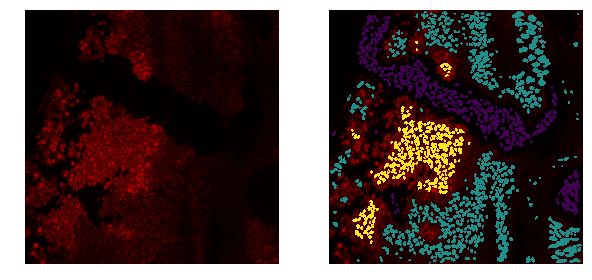

In [27]:
channel_id = 2
border_thickness = 1
interior_only = True
selection_only = False

# visualize clonal marker fluorescence
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
for ax in axes:
    fig = layer.get_channel(channel_id).show(segments=False, cmap='r', ax=ax)

# overlay assigned genotypes
layer.mark_boundaries(layer.data, max_edges=border_thickness)
mask = layer.build_attribute_mask('genotype', interior_only=interior_only, selection_only=selection_only)
_ = axes[1].imshow(mask)

# Correct for fluorescence bleed-through

First we can visualize the control reporter expression as we did before.

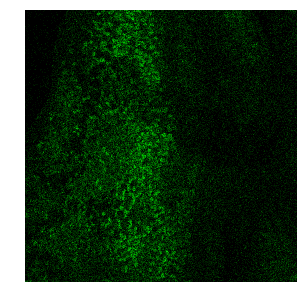

In [28]:
fig = layer.get_channel(channel=1).show(segments=False, cmap='g', figsize=(5, 5))

Bleedthrough correction must be applied on a layer-by-layer basis because each layer contains a different background region. We can fit a linear model to a layer's background bleedthrough trend using the ```LayerCorrection``` object. The ```xvar``` argument specifies the fluorescence channel from with bleedthrough originates, while the ```yvar``` argument specifies which channel is subject to bleedthrough. See the Fly-QMA documentation for additional detail regarding the remaining keyword arguments that control background pixel extraction and bleedthrough coefficient determination.

In [29]:
from flyqma.bleedthrough.correction import LayerCorrection

# perform background correction
correction = LayerCorrection(layer, xvar=2, yvar=1)

Once the model is fit, we can visualize the background determination using the ```LayerCorrection.show_background_extraction``` method. We can also visualize the bleedthrough model fit using the ```LayerCorrection.show_correction``` method.

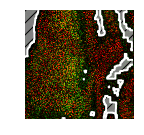

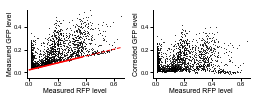

In [30]:
# visualize background extraction and model fit
_ = correction.show_background_extraction(invert=True, figsize=(2, 2))
_ = correction.show_correction(selected_only=False, figsize=(4, 1.25))

Finally, if we save the bleedthrough model using the ```LayerCorrection.save``` method, the measurements will be automatically corrected whenever the layer is loaded from file in the future.

In [31]:
correction.save()

# Analyze the processed data

Once each stack has been segmented, corrected, and annotated, we can go ahead and aggregate all of the processed measurements from a collection of related image stacks.

In [32]:
from flyqma.data import Experiment

experiment_path = '../data/replication_data/tutorial'
experiment = Experiment(experiment_path)

measurements = experiment.aggregate_measurements(selected_only=False, exclude_boundary=False)

We can then use Fly-QMA's ```statistics.CloneComparison``` tool to evaluate whether fluorescence levels differ between clones. The ```basis``` keyword argument defines which channel is used in the comparison.

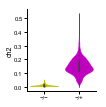

In [33]:
label_a, label_b = 0, 1

from flyqma.analysis.statistics import CloneComparison
comparison = CloneComparison(measurements, label_a, label_b, basis='ch2')
comparison.plot()

# run statistical comparison
pvalue = comparison.compare(test='MW')